In [1]:
# -*- coding: utf-8 -*-
# Renato Santos Aranha Jan/21

# ===================
# packages importing
# ===================

import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.regularizers import l2
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import pickle
import cv2
import time
import sys
from google.colab import drive

In [2]:
# Mounting google drive (requires authentication)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# ===================
# Preparing the data
# ===================

def get_data(imPaths, stanford=0, labl=1):
  print("loading images...")
  # grab the list of images in dataset directory
  imagePaths = list(paths.list_images(imPaths))
  data = []
  labels = []
  if stanford:
    labels = [labl] * len(imagePaths)
  # loop over the image path
  for imagePath in imagePaths:
    # extract class label from filename
    if stanford == 0:
      label = int(imagePath.split(".")[-2][-1])
      labels.append(label)
    # load image, swap color channels, and resize it to 224x224
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update data and labels
    data.append(image)    
  # convert data and labels to NumPy arrays while scaling pixel
  # intensities to range [0, 1]
  d = np.array(data) / 255.0
  l = np.array(labels)
  print("ok")
  return d, l


def split(data, labels, test_size=0.20, stratify=0):
  # partition data into train and test splits using 80% for training
  X = data
  y = labels
  if stratify:
    (trainX, testX, trainY, testY) = train_test_split(X, y, test_size=test_size, stratify=labels, random_state=42)
  else:
    (trainX, testX, trainY, testY) = train_test_split(X, y, test_size=test_size, random_state=42)
  return (trainX, testX, trainY, testY)

In [9]:
# =========================================
# defining tasks (Montgomery and Shenzhen)
# =========================================

# load images
data1, labels_1 = get_data('/content/drive/My Drive/Colab Notebooks/mont_CXR_png/')
(train1X, test1X, train1Y, test1Y) = split(data1, labels_1, test_size=0.20)

data2, labels_2 = get_data('/content/drive/My Drive/Colab Notebooks/shen_CXR_png/')
(train2X, test2X, train2Y, test2Y) = split(data2, labels_2, test_size=0.20)

data3_0, labels3_0 = get_data('/content/drive/My Drive/Colab Notebooks/cheX/001.Normal/', stanford=1, labl=0)
data3_1, labels3_1 = get_data('/content/drive/My Drive/Colab Notebooks/cheX/002.Pneumonia/', stanford=1, labl=1)

data3 = np.concatenate((data3_0, data3_1))
labels_3 = np.concatenate((labels3_0, labels3_1))

np.random.seed(42)
np.random.shuffle(data3)
np.random.seed(42)
np.random.shuffle(labels_3)

(train3X, test3X, train3Y, test3Y) = split(data3[0:400], labels_3[0:400], test_size=0.20)


# define tasks
task1 = [train1X, train1Y, test1X, test1Y]
task2 = [train2X, train2Y, test2X, test2Y]
task3 = [train3X, train3Y, test3X, test3Y]

# save tasks to npy files
np.save('/content/drive/My Drive/Colab Notebooks/task_montgomery.npy', task1)
np.save('/content/drive/My Drive/Colab Notebooks/task_shenzhen.npy', task2)
np.save('/content/drive/My Drive/Colab Notebooks/task_stanford1.npy', task3)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
# ========================================================
# load already saved tasks data (Montgomery and Shenzhen)
# ========================================================

# load task arrays and define tasks
task1 = np.load('/content/drive/My Drive/Colab Notebooks/task_montgomery.npy', allow_pickle=True)
task2 = np.load('/content/drive/My Drive/Colab Notebooks/task_shenzhen.npy', allow_pickle=True)
task3 = np.load('/content/drive/My Drive/Colab Notebooks/task_stanford1.npy', allow_pickle=True)

# define tasks
[train1X, train1Y, test1X, test1Y] = task1
[train2X, train2Y, test2X, test2Y] = task2
[train3X, train3Y, test3X, test3Y] = task3

data1 = np.concatenate([train1X, test1X])
labels_1 = np.concatenate([train1Y, test1Y])

data2 = np.concatenate([train2X, test2X])
labels_2 = np.concatenate([train2Y, test2Y])

data3 = np.concatenate([train3X, test3X])
labels_3 = np.concatenate([train3Y, test3Y])

(110, 224, 224, 3)
(28, 224, 224, 3)
=====
(529, 224, 224, 3)
(133, 224, 224, 3)
=====
(320, 224, 224, 3)
(80, 224, 224, 3)


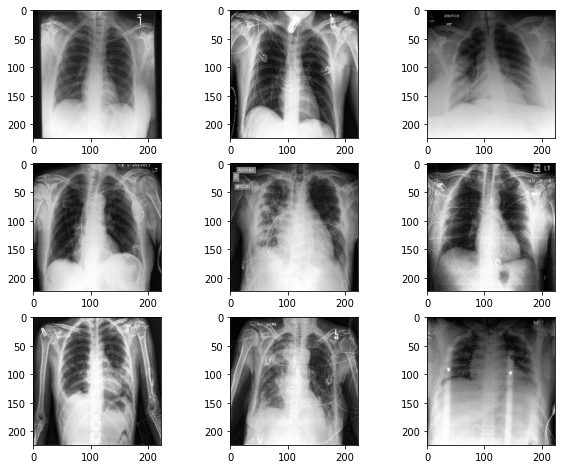

In [5]:
# ========================
# visualize sample images
# ========================

# print shapes
print(train1X.shape)
print(test1X.shape)
print("=====")
print(train2X.shape)
print(test2X.shape)
print("=====")
print(train3X.shape)
print(test3X.shape)

# plot samples
fig = plt.figure(figsize=(10, 8))
for i in range(0, len(data3[:9])):
    img = data3[i]
    fig.add_subplot(3, 3, i+1)
    plt.imshow(img)
plt.show()

In [5]:
# ======================================================================
# create a new class (keras Model as superclass) to apply EWC loss term
# ======================================================================
# ref: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

class ModelEWC(Model):
    def __init__(self, inputs, outputs, fisher_dict, optpar_dict, ewc_lambda):
        super(ModelEWC, self).__init__(inputs, outputs)
        self.fisher_dict = fisher_dict
        self.optpar_dict = optpar_dict
        self.ewc_lambda = ewc_lambda

    def get_ewc_loss(self):
        # fisher and optimized parameters are from previous task
        ewc_term = 0

        # loop over parameter names and calculate ewc loss term
        for i, j in enumerate(self.optpar_dict.keys()):
          params = self.trainable_weights
          arg_ = (0.5) * self.fisher_dict[j] * (params[i] - self.optpar_dict[j])**2
          arg = tf.math.reduce_sum(arg_)
          ewc_term += arg

        return ewc_term
        
    def train_step(self, data):
        # this function is called by .fit() method
        # Unpack the data. Its structure depends on your model and on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            ewc_term = self.get_ewc_loss()
            loss += self.ewc_lambda * ewc_term

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [6]:
# ======================================================
# build model on top of DenseNet pretrained architecure
# ======================================================
# ref: https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

def build_model(nr_classes=1, shape=(224, 224, 3), freeze_cnn = True):
   # load the DenseNet network, ensuring the head FC layer sets are left off
   base = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=shape))
   # construct the head to be placed on top of the base model
   head_FC = base.output
   head_FC = MaxPooling2D(pool_size=(2, 2))(head_FC)
   head_FC = Flatten(name="flatten")(head_FC)
   head_FC = Dropout(0.6)(head_FC)
   head_FC = Dense(64, activation="relu", kernel_regularizer=l2(0.09))(head_FC)
   head_FC = Dropout(0.6)(head_FC)
   head_FC = Dense(nr_classes, activation="sigmoid")(head_FC) 

   # place head FC model on top of base model
   model = Model(inputs=base.input, outputs=head_FC)
   
   if freeze_cnn:
     # freeze parameters in base model
     for layer in base.layers:
       layer.trainable = False
   return model

In [7]:
# ===================================
# defining custom training functions
# ===================================

def on_task_update(task, model, BS):
  loss_history = []
  grads_accum = []
  trainX, trainY, _, _ = task

  assert BS <= trainX.shape[0], "batch size should be less than training size"
 
  numUpdates = int(trainX.shape[0] / BS)

  for i in range(0, numUpdates):
    # determine starting and ending slice indexes for the current batch
    start = i * BS
    end = start + BS
    # take a step
    with tf.GradientTape() as tape:
    # make a prediction using model and calculate the loss
      pred = model(trainX[start:end])
      loss_batch = binary_crossentropy(trainY[start:end], pred[:,0])

    loss_history.append(loss_batch)
    # get gradients using tape and update model weights
    params = model.trainable_variables
    grads = tape.gradient(loss_batch, params)
    model.optimizer.apply_gradients(zip(grads, params))
    grads_accum.append(grads)
    
  epoch_loss = np.mean(loss_history)

  # saving optimized parameters and fisher information of each parameter
  param_names = [i.name for i in params]

  optpar_dict = dict(zip(param_names, params))
  fisher_dict = dict(zip(param_names, sum_list_of_tensors(grads_accum)))
  fisher_dict = {k: pow(v,2) for k,v in fisher_dict.items()}

  return fisher_dict, optpar_dict, model, epoch_loss


def train_normal(task, model, BS, EPOCHS):

  epoch_loss_history = []

  for epoch in range(0, EPOCHS):
    print("[INFO] epoch {}/{} ".format(epoch + 1, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
   
    # loop over data in batch size increments, and take grads, params and model
    fisher_dict, optpar_dict, M, epoch_loss = on_task_update(task, model, BS)
    model = M

    epoch_loss_history.append(epoch_loss)

    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("- loss {} - {:.4} mins".format(epoch_loss, elapsed))
  
  print("===============")
  
  return fisher_dict, optpar_dict, model, epoch_loss_history


def get_ewc_loss(fisher_dict, optpar_dict, model, lambd):
  # fisher and optimized parameters are from previous task
  ewc_term = 0

  # loop over parameter names and calculate ewc loss term
  for i, j in enumerate(optpar_dict.keys()):
    params = model.trainable_weights
    arg_ = (0.5) * fisher_dict[j] * (params[i] - optpar_dict[j])**2
    arg = tf.math.reduce_sum(arg_)
    ewc_term += arg

  return lambd * ewc_term


def feedforwardstep_ewc(X, y, fisher_dict, optpar_dict, model, lambd):
  # keep track of gradients
  with tf.GradientTape() as tape:
    # make a prediction using model and calculate the loss
    pred = model(X)
    loss = binary_crossentropy(y, pred[:,0])
 
    ewc_term = get_ewc_loss(fisher_dict, optpar_dict, model, lambd)
    loss += ewc_term
  
  # calculate gradients using tape and update model weights
  parameters = model.trainable_variables
  grads = tape.gradient(loss, parameters)
  model.optimizer.apply_gradients(zip(grads, parameters))

  return model, loss


def train_ewc(task, model, BS, EPOCHS, fisher_dict, optpar_dict, ewc_lambd=1):

  trainX, trainY, _, _ = task
  numUpdates = int(trainX.shape[0] / BS)
  epoch_loss_history = []
  
  for epoch in range(0, EPOCHS):
    print("[INFO] epoch {}/{} ".format(epoch + 1, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    
    batch_loss_history = []
    
    for i in range(0, numUpdates):
      start = i * BS
      end = start + BS
      # take a step
      model, loss_batch = feedforwardstep_ewc(trainX[start:end],
                                              trainY[start:end],
                                              fisher_dict,
                                              optpar_dict,
                                              model,
                                              ewc_lambd)
      batch_loss_history.append(loss_batch)
    
    epoch_loss_history.append(np.mean(batch_loss_history))

    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("- loss {} - {:.4} mins".format(np.mean(epoch_loss_history), elapsed))

  return model, epoch_loss_history


# ==================================================================
# create a function to calculate accumulated gradients over batches
# ==================================================================

def sum_list_of_tensors(grads_accum):
    """
    function to calculate accumulated gradients over batches.
    grads: list of lists (where each inner list contains a layer gradients
    """

    res = list()

    for i in range(0, len(grads_accum[0])):
      tmp = []
      for j in range(0, len(grads_accum)):
        tmp.append(grads_accum[j][i])
      sum = tf.math.add_n(tmp)
      res.append(sum)
    
    return res

In [22]:
# =============================
# set training hyperparameters
# =============================

# number of epochs, batch size and learning rate
EPOCHS = 30
BS = 32
LR = 1e-3

# build model and initialize optimizer
M1 = build_model()
M2 = build_model()
M3 = build_model()

M1.compile(optimizer=Adam(lr=LR, decay=LR / EPOCHS),
              loss="binary_crossentropy",
              metrics="accuracy")

M2.compile(optimizer=Adam(lr=LR, decay=LR / EPOCHS),
              loss="binary_crossentropy",
              metrics="accuracy")

M3.compile(optimizer=Adam(lr=LR, decay=LR / EPOCHS),
              loss="binary_crossentropy",
              metrics="accuracy")

In [23]:
# # ====================================================================
# # calculate fisher information and optimized parameters for each task
# # ====================================================================

# fisher_dict1, optpar_dict1, model1, loss_history1 = train_normal(task1, M1, BS, EPOCHS)
# fisher_dict2, optpar_dict2, model2, loss_history2 = train_normal(task2, M2, 16, EPOCHS)
fisher_dict3, optpar_dict3, model3, loss_history3 = train_normal(task3, M3, 32, EPOCHS)

[INFO] epoch 1/30 - loss 2.029881477355957 - 0.06143 mins
[INFO] epoch 2/30 - loss 0.693543016910553 - 0.0591 mins
[INFO] epoch 3/30 - loss 0.5675566792488098 - 0.05729 mins
[INFO] epoch 4/30 - loss 0.4762757420539856 - 0.05751 mins
[INFO] epoch 5/30 - loss 0.3937612473964691 - 0.05845 mins
[INFO] epoch 6/30 - loss 0.3428524434566498 - 0.05818 mins
[INFO] epoch 7/30 - loss 0.31265789270401 - 0.05747 mins
[INFO] epoch 8/30 - loss 0.2826041579246521 - 0.05868 mins
[INFO] epoch 9/30 - loss 0.2524791955947876 - 0.05906 mins
[INFO] epoch 10/30 - loss 0.22422704100608826 - 0.05777 mins
[INFO] epoch 11/30 - loss 0.19873939454555511 - 0.05932 mins
[INFO] epoch 12/30 - loss 0.17662402987480164 - 0.05839 mins
[INFO] epoch 13/30 - loss 0.15668508410453796 - 0.0642 mins
[INFO] epoch 14/30 - loss 0.13893137872219086 - 0.05845 mins
[INFO] epoch 15/30 - loss 0.12355220317840576 - 0.05902 mins
[INFO] epoch 16/30 - loss 0.10996675491333008 - 0.05944 mins
[INFO] epoch 17/30 - loss 0.09795056283473969 - 

In [25]:
# ============================================
# save dicts, model and loss history to files
# ============================================

#  saving dicts
f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict1.pkl", "wb")
pickle.dump(fisher_dict1, f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict2.pkl", "wb")
pickle.dump(fisher_dict2, f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict3.pkl", "wb")
pickle.dump(fisher_dict3, f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict1.pkl", "wb")
pickle.dump(optpar_dict1, f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict2.pkl", "wb")
pickle.dump(optpar_dict2, f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict3.pkl", "wb")
pickle.dump(optpar_dict3, f)
f.close()

# saving models
model1.save('/content/drive/My Drive/Colab Notebooks/model1.h5')
model2.save('/content/drive/My Drive/Colab Notebooks/model2.h5')
model3.save('/content/drive/My Drive/Colab Notebooks/model3.h5')

# saving loss history
with open("/content/drive/My Drive/Colab Notebooks/loss_history1.pkl", "wb") as f:
  pickle.dump(loss_history1, f)

with open("/content/drive/My Drive/Colab Notebooks/loss_history2.pkl", "wb") as f:
  pickle.dump(loss_history2, f)

with open("/content/drive/My Drive/Colab Notebooks/loss_history3.pkl", "wb") as f:
  pickle.dump(loss_history3, f)

In [8]:
# ==================================================
# load saved files of dicts, model and loss history
# ==================================================

# load dicts

f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict1.pkl", "rb")
fisher_dict1 = pickle.load(f)

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict1.pkl", "rb")
optpar_dict1 = pickle.load(f)

f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict2.pkl", "rb")
fisher_dict2 = pickle.load(f)

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict2.pkl", "rb")
optpar_dict2 = pickle.load(f)

f = open("/content/drive/My Drive/Colab Notebooks/fisher_dict3.pkl", "rb")
fisher_dict3 = pickle.load(f)

f = open("/content/drive/My Drive/Colab Notebooks/optpar_dict3.pkl", "rb")
optpar_dict3 = pickle.load(f)

# load models
# model1 = load_model('/content/drive/My Drive/Colab Notebooks/model1.h5')
# model2 = load_model('/content/drive/My Drive/Colab Notebooks/model2.h5')

# # load loss history
# with open("/content/drive/My Drive/Colab Notebooks/loss_history1.pkl", "rb") as f:
#   loss_history1 = pickle.load(f)

# with open("/content/drive/My Drive/Colab Notebooks/loss_history2.pkl", "rb") as f:
#   loss_history2 = pickle.load(f)

In [ ]:
# ====================================
# train EWC model (task 1 --> task 2)
# ====================================

BS=16
EPOCHS=30
modelo12, loss_historico = train_ewc(task2, model1, BS, EPOCHS, fisher_dict1, optpar_dict1, ewc_lambd=0.7)

In [ ]:
# ===================================================
# evaluate EWC model (task 1 --> task2) on test data
# ===================================================

# in order to calculate accuracy using Keras' functions we first need to compile the model
modelo12.compile(metrics=["acc"])
# now that the model is compiled we can compute the accuracy

testX, testY = task1[0], task1[1]
(loss, acc) = modelo12.evaluate(testX, testY, batch_size=1)
print("[INFO] task1 test accuracy: {:.4f}".format(acc))

testX, testY = task2[0], task2[1]
(loss, acc) = modelo12.evaluate(testX, testY, batch_size=1)
print("[INFO] task2 test accuracy: {:.4f}".format(acc))

In [9]:
# =====================================================
# function to plot train metrics evolution over epochs
# =====================================================

def plot_training(epochs, metric, ref_dict):
  val_metric = f"val_{metric}"
  
  means_acc = []
  stds_acc = []
  means_val_acc = []
  stds_val_acc = []

  for i in range(epochs):
    means_acc.append(np.mean(ref_dict[f"epoch_{i}"][metric]))
    stds_acc.append(np.std(ref_dict[f"epoch_{i}"][metric]))
    means_val_acc.append(np.mean(ref_dict[f"epoch_{i}"][val_metric]))
    stds_val_acc.append(np.std(ref_dict[f"epoch_{i}"][val_metric]))

  fig, ax = plt.subplots(figsize=(13, 6))

  ax.plot(range(1, epochs+1), means_acc, "-", label=metric)
  ax.set_xticks(range(1, epochs+1))
  ax.text(20, means_acc[19], round(means_acc[19],2))
  ax.grid(True, alpha=0.5)
  
  if metric != 'loss':
    ax.set_ylim(0,1)
    
  ax.fill_between(range(1, epochs+1),
                  [i - j for i, j in zip(means_acc, stds_acc)],
                  [i + j for i, j in zip(means_acc, stds_acc)],
                  alpha=0.3)
  ax.legend(loc='upper center')

  ax.plot(range(1, epochs+1), means_val_acc, "-", label=val_metric)
  ax.text(20, means_val_acc[19], round(means_val_acc[19],2))
  ax.grid(True, alpha=0.5)
  ax.fill_between(range(1, epochs+1),
                  [i - j for i, j in zip(means_val_acc, stds_val_acc)],
                  [i + j for i, j in zip(means_val_acc, stds_val_acc)],
                  alpha=0.3)
  ax.legend(loc='upper center')


# ====================================================
# function to plot tasks model performance over epochs
# ====================================================

def plot_performance(epochs, metric, ref_dict1, ref_dict2):
  means_acc = []
  stds_acc = []
  means_val_acc = []
  stds_val_acc = []

  for i in range(epochs):
    means_acc.append(np.mean(ref_dict1[f"epoch_{i}"][metric]))
    stds_acc.append(np.std(ref_dict1[f"epoch_{i}"][metric]))
    means_val_acc.append(np.mean(ref_dict2[f"epoch_{i}"][metric]))
    stds_val_acc.append(np.std(ref_dict2[f"epoch_{i}"][metric]))

  fig, ax = plt.subplots(figsize=(13, 6))

  ax.plot(range(1, epochs+1), means_acc, "-", label=f"task 2 {metric}")
  ax.set_xticks(range(1, epochs+1))
  ax.text(20, means_acc[19], round(means_acc[19],2))
  ax.grid(True, alpha=0.5)
  
  if metric != 'loss':
    ax.set_ylim(0,1)

  ax.fill_between(range(1, epochs+1),
                  [i - j for i, j in zip(means_acc, stds_acc)],
                  [i + j for i, j in zip(means_acc, stds_acc)],
                  alpha=0.3)
  ax.legend(loc='upper center')

  ax.plot(range(1, epochs+1), means_val_acc, "-", label=f"task 3 {metric}")
  ax.text(20, means_val_acc[19], round(means_val_acc[19],2))
  ax.grid(True, alpha=0.5)
  ax.fill_between(range(1, epochs+1),
                  [i - j for i, j in zip(means_val_acc, stds_val_acc)],
                  [i + j for i, j in zip(means_val_acc, stds_val_acc)],
                  alpha=0.3)
  ax.legend(loc='upper center')

In [21]:
# ====================================================================
# setting cross validation scheme (using EWC model from custom class)
# ====================================================================

# for train, test in kfold.split(X,Y):
# 	print('train: %s, test: %s' % (X[train].shape, X[test].shape))

X = data3[0:250]
Y = labels_3[0:250]
splits = 5
epochs = 20
batchSize = 32
ewc_lambda = 10

train_metrics_dict = {}
task1_ewc = {}
task2_ewc = {}
task3_ewc = {}

k_fold = KFold(n_splits=splits, shuffle=True, random_state=42)

metrics=["acc",
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()]

for i in range(0, epochs):
      train_metrics_dict.update({"epoch_{}".format(i):{'acc':[]}})
      train_metrics_dict["epoch_{}".format(i)].update({'val_acc':[]})
      train_metrics_dict["epoch_{}".format(i)].update({'rec':[]})
      train_metrics_dict["epoch_{}".format(i)].update({'val_rec':[]})
      train_metrics_dict["epoch_{}".format(i)].update({'prec':[]}) 
      train_metrics_dict["epoch_{}".format(i)].update({'val_prec':[]})
      train_metrics_dict["epoch_{}".format(i)].update({'loss':[]}) 
      train_metrics_dict["epoch_{}".format(i)].update({'val_loss':[]}) 

      task1_ewc.update({"epoch_{}".format(i):{'acc':[]}})
      task1_ewc["epoch_{}".format(i)].update({'rec':[]})
      task1_ewc["epoch_{}".format(i)].update({'prec':[]})
      task1_ewc["epoch_{}".format(i)].update({'loss':[]})
      
      task2_ewc.update({"epoch_{}".format(i):{'acc':[]}})
      task2_ewc["epoch_{}".format(i)].update({'rec':[]})
      task2_ewc["epoch_{}".format(i)].update({'prec':[]})
      task2_ewc["epoch_{}".format(i)].update({'loss':[]})

      task3_ewc.update({"epoch_{}".format(i):{'acc':[]}})
      task3_ewc["epoch_{}".format(i)].update({'rec':[]})
      task3_ewc["epoch_{}".format(i)].update({'prec':[]})
      task3_ewc["epoch_{}".format(i)].update({'loss':[]})

for k, (train, val) in enumerate(k_fold.split(X, Y)):
    print("[fold {0}]".format(k))
    
    baseModel = build_model()

    EWC = ModelEWC(inputs=baseModel.input,
                   outputs=baseModel.output,
                   fisher_dict=fisher_dict2,
                   optpar_dict=optpar_dict2,
                   ewc_lambda=ewc_lambda)

    EWC.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics=metrics)
    
    EWC.load_weights("/content/drive/My Drive/Colab Notebooks/main_task2_only.h5")
    
    for i in range(0, epochs):
      H = EWC.fit(x=X[train], y=Y[train], epochs=1, batch_size=batchSize, validation_data=(X[val], Y[val]))
      train_metrics_dict["epoch_{}".format(i)]['loss'].append([H.history[i] for i in H.history.keys() if "loss" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['val_loss'].append([H.history[i] for i in H.history.keys() if "val_loss" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['acc'].append([H.history[i] for i in H.history.keys() if "acc" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['val_acc'].append([H.history[i] for i in H.history.keys() if "val_acc" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['prec'].append([H.history[i] for i in H.history.keys() if "prec" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['val_prec'].append([H.history[i] for i in H.history.keys() if "val_prec" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['rec'].append([H.history[i] for i in H.history.keys() if "rec" in i][0])
      train_metrics_dict["epoch_{}".format(i)]['val_rec'].append([H.history[i] for i in H.history.keys() if "val_rec" in i][0])

      a,b,c,d = EWC.evaluate(data1, labels_1, batch_size=batchSize)
      task1_ewc["epoch_{}".format(i)]['loss'].append(a)
      task1_ewc["epoch_{}".format(i)]['acc'].append(b)
      task1_ewc["epoch_{}".format(i)]['prec'].append(c)
      task1_ewc["epoch_{}".format(i)]['rec'].append(d)     
      
      a,b,c,d = EWC.evaluate(data2, labels_2, batch_size=batchSize)
      task2_ewc["epoch_{}".format(i)]['loss'].append(a)
      task2_ewc["epoch_{}".format(i)]['acc'].append(b)
      task2_ewc["epoch_{}".format(i)]['prec'].append(c)
      task2_ewc["epoch_{}".format(i)]['rec'].append(d)
      
      a,b,c,d = EWC.evaluate(data3, labels_3, batch_size=batchSize)
      task3_ewc["epoch_{}".format(i)]['loss'].append(a)
      task3_ewc["epoch_{}".format(i)]['acc'].append(b)
      task3_ewc["epoch_{}".format(i)]['prec'].append(c)
      task3_ewc["epoch_{}".format(i)]['rec'].append(d)   

[fold 0]
13/13 [==============================] - 1s 93ms/step - loss: 0.7833 - acc: 0.8075 - precision_5: 0.8265 - recall_5: 0.7902
[fold 1]
13/13 [==============================] - 1s 95ms/step - loss: 0.7285 - acc: 0.7975 - precision_5: 0.8069 - recall_5: 0.7951
[fold 2]
13/13 [==============================] - 1s 93ms/step - loss: 0.7217 - acc: 0.8150 - precision_5: 0.8195 - recall_5: 0.8195
[fold 3]
13/13 [==============================] - 1s 95ms/step - loss: 0.7562 - acc: 0.8175 - precision_5: 0.8173 - recall_5: 0.8293
[fold 4]
13/13 [==============================] - 1s 95ms/step - loss: 0.7592 - acc: 0.8150 - precision_5: 0.8541 - recall_5: 0.7707


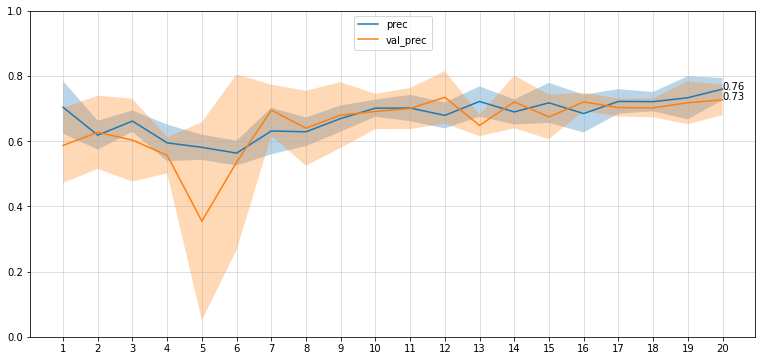

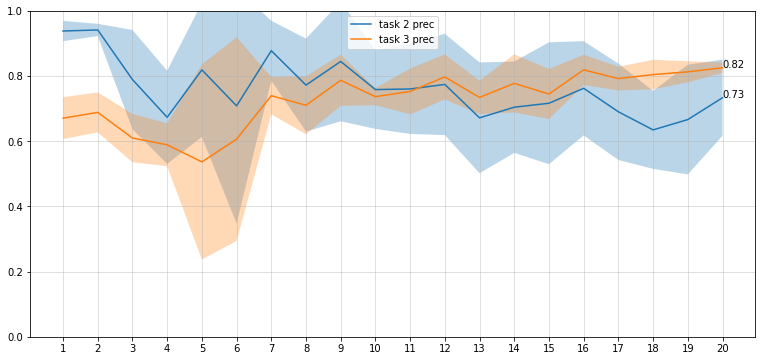

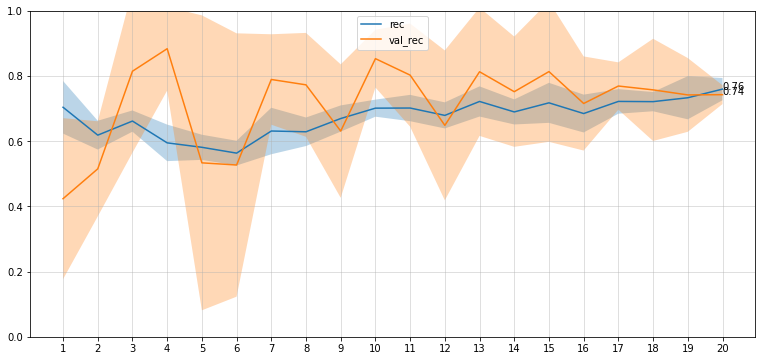

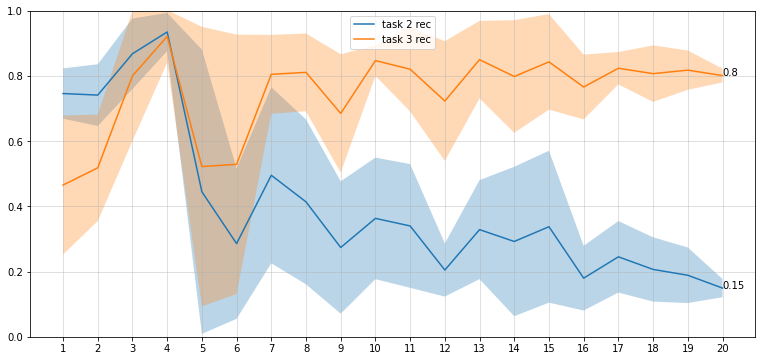

In [22]:
m = 'prec'
plot_training(epochs=20, metric=m, ref_dict=train_metrics_dict)
plot_performance(epochs=20, metric=m, ref_dict1=task2_ewc, ref_dict2=task3_ewc)

m = 'rec'
plot_training(epochs=20, metric=m, ref_dict=train_metrics_dict)
plot_performance(epochs=20, metric=m, ref_dict1=task2_ewc, ref_dict2=task3_ewc)

In [ ]:
========================
save/load model weights
========================

f = open("/content/drive/My Drive/Colab Notebooks/ewc_weights_task2.pkl", "wb")
pickle.dump(EWC.get_weights(), f)
f.close()

f = open("/content/drive/My Drive/Colab Notebooks/ewc_weights.pkl", "rb")
wght = pickle.load(f)
a = np.array(wght)
EWC.set_weights(a)

In [ ]:
# ===============================
# save training and testing logs
# ===============================

# EWC.save("/content/drive/My Drive/Colab Notebooks/main_task2_only.h5")
f1 = open("/content/drive/My Drive/Colab Notebooks/main_train_metrics_dict12_0.pkl", "wb")
f2 = open("/content/drive/My Drive/Colab Notebooks/main_task1_ewc12_0.pkl", "wb")
f3 = open("/content/drive/My Drive/Colab Notebooks/main_task2_ewc12_0.pkl", "wb")

pickle.dump(train_metrics_dict, f1)
pickle.dump(task1_ewc, f2)
pickle.dump(task2_ewc, f3)

f1.close()
f2.close()
f3.close()

In [ ]:
# ===============================
# load training and testing logs
# ===============================

# loading dicts
f1 = open("/content/drive/My Drive/Colab Notebooks/train_metrics_dict2.pkl", "rb")
f2 = open("/content/drive/My Drive/Colab Notebooks/task1_ewc2.pkl", "rb")
f3 = open("/content/drive/My Drive/Colab Notebooks/task2_ewc2.pkl", "rb")

train_metrics_dict = pickle.load(f1)
task1_ewc2 = pickle.load(f2)
task2_ewc2 = pickle.load(f3)